# Model Comparison & Selection

In this notebook, we compare several candidate classifiers using cross-validation and ROC AUC to identify the best-performing models for our use case. The input data is already preprocessed: 
We have handled missing values and deduplication strategies outside of the modeling pipeline and created a pipeline for simpler preprocessing methods. 

Train/Test Split or 5-fold cross-validation
Models:
- Logistic Regression baseline 
- Additional models: Random Forest, Gradient Boosting (XGBoost), Neural Network, SVM with RBF Kernel

Pipeline Setup: 5-fold crossvalidation
Use StratifiedKfold to ensure that each fold in the cross-validation process has approximately the same proportion of target classes (recidivist vs. non-recidivist) as the full dataset. 
The is_recid target is imbalanced (around 30–35% positive class).

c:\Users\wastl\modelengineering\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


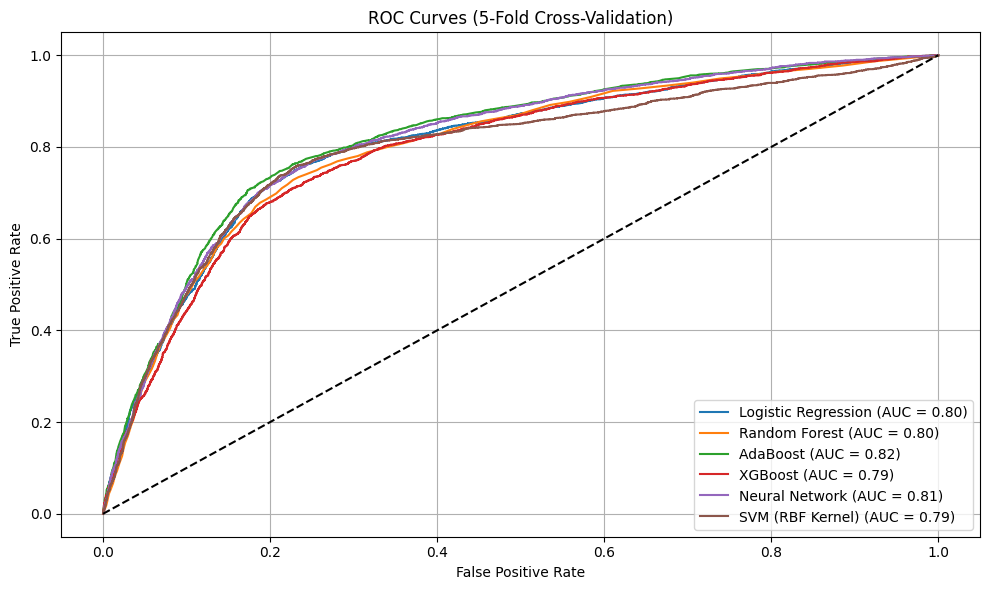

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Logistic Regression,0.770,0.681,0.592,0.633,0.805
1,Random Forest,0.769,0.669,0.616,0.641,0.800
2,AdaBoost,0.784,0.686,0.657,0.671,0.820
3,XGBoost,0.763,0.660,0.607,0.632,0.794
4,Neural Network,0.774,0.680,0.612,0.644,0.814
5,SVM (RBF Kernel),0.769,0.690,0.567,0.623,0.793


In [10]:
# === Model Selection with Pipeline and 7 Selected Features ===

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Load Full Preprocessed Data & Pipeline
df_full = pd.read_csv("../data/cox-violent-preprocessed.csv")
pipeline = joblib.load("../models/pipeline_preprocessing.pkl")

# Separate X and y BEFORE selecting features
X_raw = df_full.drop("is_recid", axis=1)
y = df_full["is_recid"]

# Apply pipeline to full X
X_transformed = pipeline.transform(X_raw)

# Narrow down to the 7 modeling features using their column positions
# Manually map from original column names to indices for modeling
selected_features = [
    "age", "sex", "juv_misd_count", "juv_fel_count",
    "priors_count", "c_charge_degree", "c_charge_desc"
]
column_order = list(X_raw.columns)
selected_indices = [column_order.index(col) for col in selected_features]
X_selected = X_transformed[:, selected_indices]

# === Step 5: Train/Val/Test Split ===
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_selected, y, test_size=0.15, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, stratify=y_trainval, random_state=42
)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# === Step 6: Define and Train Models ===
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "Random Forest": Pipeline([
        ("clf", RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
    "AdaBoost": Pipeline([
        ("clf", AdaBoostClassifier(n_estimators=100, random_state=42))
    ]),
    "XGBoost": Pipeline([
        ("clf", XGBClassifier(eval_metric='logloss', random_state=42))
    ]),
    "Neural Network": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(64,), max_iter=300, random_state=42))
    ]),
    "SVM (RBF Kernel)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel='rbf', probability=True, random_state=42))
    ])
}

results = []
plt.figure(figsize=(10, 6))

for name, model in models.items():
    y_proba = cross_val_predict(model, X_trainval, y_trainval, cv=cv, method="predict_proba")[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    results.append({
        "Model": name,
        "Accuracy": round(accuracy_score(y_trainval, y_pred), 3),
        "Precision": round(precision_score(y_trainval, y_pred), 3),
        "Recall": round(recall_score(y_trainval, y_pred), 3),
        "F1 Score": round(f1_score(y_trainval, y_pred), 3),
        "AUC": round(roc_auc_score(y_trainval, y_proba), 3)
    })

    fpr, tpr, _ = roc_curve(y_trainval, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_trainval, y_proba):.2f})")

# Plot ROC Curves
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (5-Fold Cross-Validation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../reports/02_modeling/model_comparison_roc_curves.png")
plt.show()

# Results Table
results_df = pd.DataFrame(results)
model_order = [
    "Logistic Regression", "Random Forest", "AdaBoost", "XGBoost", "Neural Network", "SVM (RBF Kernel)"
]
results_df["Model"] = pd.Categorical(results_df["Model"], categories=model_order, ordered=True)
results_df = results_df.sort_values("Model").reset_index(drop=True)
results_df.to_csv("../reports/02_modeling/model_performance_comparison_5-foldcv.csv", index=False)
results_df


Pipeline Setup: alternatively 80/20 Train/Test Split

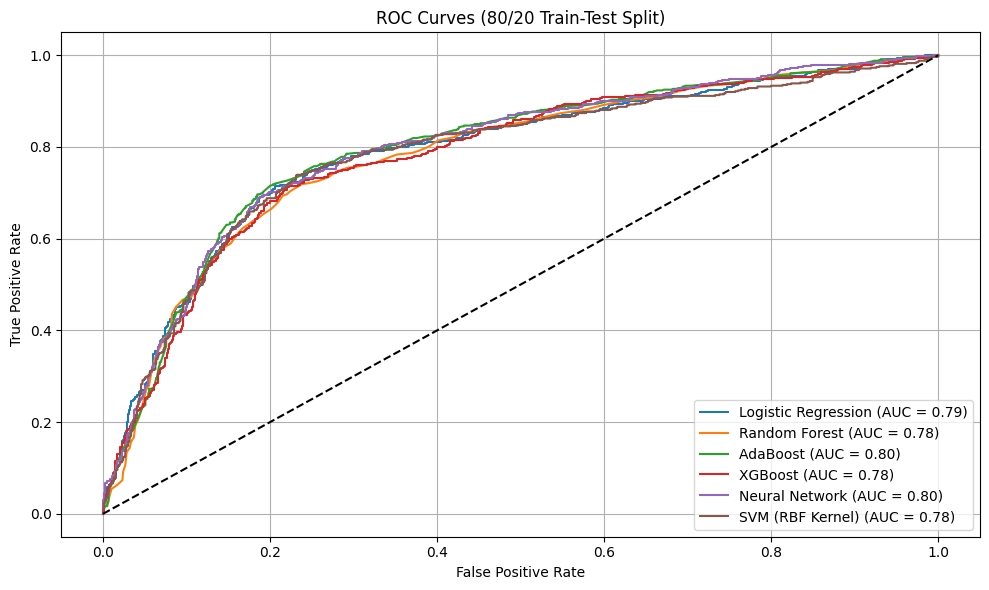

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Logistic Regression,0.767,0.670,0.600,0.633,0.790
1,Random Forest,0.761,0.660,0.589,0.623,0.784
2,AdaBoost,0.776,0.671,0.651,0.661,0.797
3,XGBoost,0.760,0.647,0.622,0.634,0.783
4,Neural Network,0.770,0.671,0.615,0.642,0.796
5,SVM (RBF Kernel),0.769,0.672,0.608,0.639,0.784


In [11]:
# Re-import required packages after kernel reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

# === Load Full Preprocessed Data & Pipeline ===
df_full = pd.read_csv("../data/cox-violent-preprocessed.csv")
pipeline = joblib.load("../models/pipeline_preprocessing.pkl")

# Separate X and y BEFORE selecting features
X_raw = df_full.drop("is_recid", axis=1)
y = df_full["is_recid"]

# Apply pipeline to full X
X_transformed = pipeline.transform(X_raw)

# Narrow down to the 7 modeling features using their column positions
# Manually map from original column names to indices for modeling
selected_features = [
    "age", "sex", "juv_misd_count", "juv_fel_count",
    "priors_count", "c_charge_degree", "c_charge_desc"
]
column_order = list(X_raw.columns)
selected_indices = [column_order.index(col) for col in selected_features]
X_selected = X_transformed[:, selected_indices]

# 85% train/val, 15% test split
X_trainval, X_test, y_trainval, y_test = train_test_split(X_selected, y, test_size=0.15, stratify=y, random_state=42)

# 80% train / 20% val within train/val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, stratify=y_trainval, random_state=42)

# Define models with pipelines
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "Random Forest": Pipeline([
        ("clf", RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
    "AdaBoost": Pipeline([
        ("clf", AdaBoostClassifier(n_estimators=100, random_state=42))
    ]),
    "XGBoost": Pipeline([
        ("clf", XGBClassifier(eval_metric='logloss', random_state=42))
    ]),
    "Neural Network": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(64,), max_iter=300, random_state=42))
    ]),
    "SVM (RBF Kernel)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel='rbf', probability=True, random_state=42))
    ])
}

# Evaluate each model
results = []
plt.figure(figsize=(10, 6))

for name, model in models.items():
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_val)[:, 1]
    y_pred = model.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_proba)

    fpr, tpr, _ = roc_curve(y_val, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

    results.append({
        "Model": name,
        "Accuracy": round(acc, 3),
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1 Score": round(f1, 3),
        "AUC": round(auc, 3)
    })

# Plot formatting
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (80/20 Train-Test Split)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../reports/02_modeling/model_comparison_roc_curves_80-20split.png")
plt.show()

# Show results
results_df = pd.DataFrame(results)

# Define fixed order of models
model_order = [
    "Logistic Regression",
    "Random Forest",
    "AdaBoost",
    "XGBoost",
    "Neural Network",
    "SVM (RBF Kernel)"
]

# Create DataFrame and sort by model order
results_df = pd.DataFrame(results)
results_df["Model"] = pd.Categorical(results_df["Model"], categories=model_order, ordered=True)
results_df = results_df.sort_values("Model").reset_index(drop=True)
results_df.to_csv("../reports/02_modeling/model_performance_comparison_80-20ttsplit.csv", index=False)
results_df



Hyperparameter Tuning: 
Include GridSearch for each model. 

In [ ]:
# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib, os

from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve
)

# Load preprocessed dataset and pipeline 
df = pd.read_csv("../data/cox-violent-preprocessed.csv")
pipeline = joblib.load("../models/pipeline_preprocessing.pkl")

# Extract raw X and y 
X_raw = df.drop("is_recid", axis=1).copy()
y = df["is_recid"].copy()

#  Apply pipeline 
X_transformed = pipeline.transform(X_raw)

# Select only the 7 modeling features
selected_features = [
    "age", "sex", "juv_misd_count", "juv_fel_count",
    "priors_count", "c_charge_degree", "c_charge_desc"
]
feature_indices = [X_raw.columns.get_loc(f) for f in selected_features]
X_selected = X_transformed[:, feature_indices]

# Train/Val/Test Split 
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_selected, y, test_size=0.15, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, stratify=y_trainval, random_state=42
)

# Apply 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define models
base_models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "Random Forest": Pipeline([
        ("clf", RandomForestClassifier(random_state=42))
    ]),
    "AdaBoost": Pipeline([
        ("clf", AdaBoostClassifier(random_state=42))
    ]),
    "XGBoost": Pipeline([
        ("clf", XGBClassifier(eval_metric='logloss', random_state=42))
    ]),
    "Neural Network": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(max_iter=300, random_state=42))
    ]),
    "SVM (RBF Kernel)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel='rbf', probability=True, random_state=42))
    ])
}

# Define hyperparameter grids
param_grids = {
    "Logistic Regression": {
        "clf__C": [0.01, 0.1, 1, 10]
    },
    "Random Forest": {
        "clf__n_estimators": [100, 200],
        "clf__max_depth": [None, 10, 20],
        "clf__min_samples_split": [2, 5]
    },
    "AdaBoost": {
        "clf__n_estimators": [50, 100, 200],
        "clf__learning_rate": [0.5, 1.0]
    },
    "XGBoost": {
        "clf__n_estimators": [50, 100],
        "clf__max_depth": [3, 5],
        "clf__learning_rate": [0.1, 0.3]
    },
    "Neural Network": {
        "clf__hidden_layer_sizes": [(32,), (64,), (64, 32)],
        "clf__alpha": [0.0001, 0.001]
    },
    "SVM (RBF Kernel)": {
        "clf__C": [0.1, 1, 10],
        "clf__gamma": ['scale', 0.01, 0.1]
    }
}


# Placeholder for storing results
results = []
plt.figure(figsize=(10, 6))

for name in base_models:
    print(f"Tuning {name}...")
    grid = GridSearchCV(base_models[name], param_grids[name], cv=cv, scoring="roc_auc", n_jobs=-1)
    grid.fit(X_trainval, y_trainval)
    best_model = grid.best_estimator_

    y_proba = best_model.predict_proba(X_trainval)[:, 1]
    y_pred = best_model.predict(X_trainval)

    acc = accuracy_score(y_trainval, y_pred)
    precision = precision_score(y_trainval, y_pred)
    recall = recall_score(y_trainval, y_pred)
    f1 = f1_score(y_trainval, y_pred)
    auc = roc_auc_score(y_trainval, y_proba)

    fpr, tpr, _ = roc_curve(y_trainval, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

    results.append({
        "Model": name,
        "Accuracy": round(acc, 3),
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1 Score": round(f1, 3),
        "AUC": round(auc, 3),
        "Best Params": grid.best_params_
    })

# ROC Plot and Save Results 
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (5-Fold CV with GridSearch)")
plt.legend()
plt.grid(True)
plt.tight_layout()
os.makedirs("../reports/02_modeling", exist_ok=True)
plt.savefig("../reports/02_modeling/model_comparison_roc_cv_tuned.png")
plt.show()

# Save Results Table 
results_df = pd.DataFrame(results)
model_order = [
    "Logistic Regression", "Random Forest", "AdaBoost",
    "XGBoost", "Neural Network", "SVM (RBF Kernel)"
]
results_df["Model"] = pd.Categorical(results_df["Model"], categories=model_order, ordered=True)
results_df = results_df.sort_values("Model").reset_index(drop=True)
results_df.to_csv("../reports/02_modeling/model_performance_comparison_cv_tuned_results.csv", index=False)
results_df


Tuning Logistic Regression...


Tuning Logistic Regression...
Tuning Random Forest...
Tuning AdaBoost...
Tuning XGBoost...
Tuning Neural Network...
Tuning SVM (RBF Kernel)...


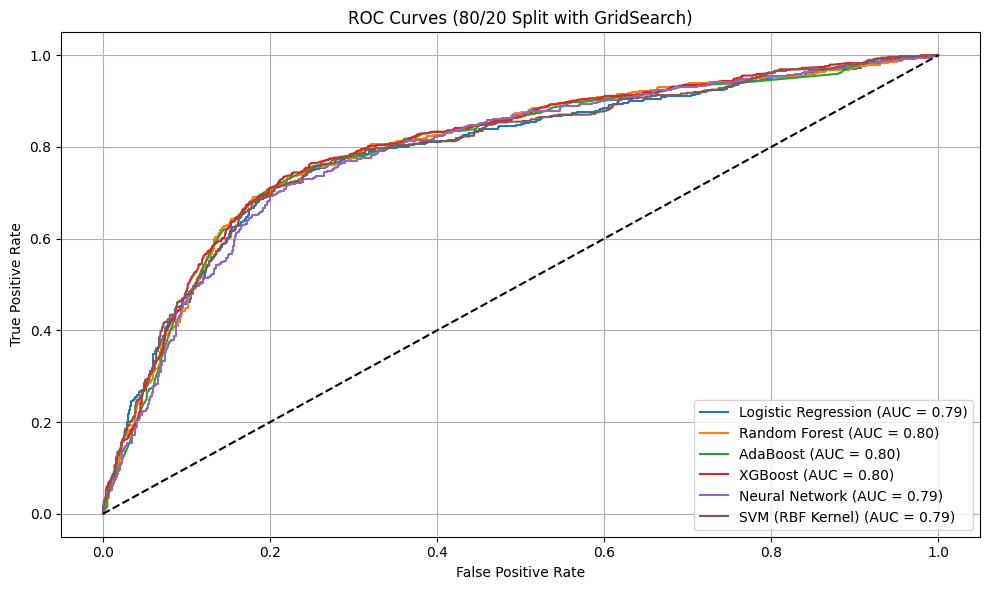

,Model,Accuracy,Precision,Recall,F1 Score,AUC,Best Params
0,Logistic Regression,0.767,0.670,0.600,0.633,0.790,{'clf__C': 1}
1,Random Forest,0.776,0.665,0.666,0.666,0.798,"{'clf__max_depth': 10, 'clf__n_estimators': 200}"
2,AdaBoost,0.774,0.667,0.651,0.659,0.796,"{'clf__learning_rate': 1.0, 'clf__n_estimators..."
3,XGBoost,0.776,0.664,0.673,0.668,0.803,"{'clf__learning_rate': 0.1, 'clf__max_depth': ..."
4,Neural Network,0.764,0.655,0.622,0.638,0.789,"{'clf__alpha': 0.0001, 'clf__hidden_layer_size..."
5,SVM (RBF Kernel),0.769,0.669,0.617,0.642,0.793,"{'clf__C': 1, 'clf__gamma': 0.01}"


In [14]:
# Model comparison 80/20 split with GridSearch

# Import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve
)

# === Load Full Preprocessed Data & Pipeline ===
df_full = pd.read_csv("../data/cox-violent-preprocessed.csv")
pipeline = joblib.load("../models/pipeline_preprocessing.pkl")

# Separate X and y BEFORE selecting features
X_raw = df_full.drop("is_recid", axis=1)
y = df_full["is_recid"]

# Apply pipeline to full X
X_transformed = pipeline.transform(X_raw)

# Narrow down to the 7 modeling features using their column positions
# Manually map from original column names to indices for modeling
selected_features = [
    "age", "sex", "juv_misd_count", "juv_fel_count",
    "priors_count", "c_charge_degree", "c_charge_desc"
]
column_order = list(X_raw.columns)
selected_indices = [column_order.index(col) for col in selected_features]
X_selected = X_transformed[:, selected_indices]

# 85% train/val, 15% test split
X_trainval, X_test, y_trainval, y_test = train_test_split(X_selected, y, test_size=0.15, stratify=y, random_state=42)

# 80% train / 20% val within train/val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, stratify=y_trainval, random_state=42)

# Define models and parameter grids
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "Random Forest": Pipeline([
        ("clf", RandomForestClassifier(random_state=42))
    ]),
    "AdaBoost": Pipeline([
        ("clf", AdaBoostClassifier(random_state=42))
    ]),
    "XGBoost": Pipeline([
        ("clf", XGBClassifier(eval_metric='logloss', random_state=42))
    ]),
    "Neural Network": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(max_iter=300, random_state=42))
    ]),
    "SVM (RBF Kernel)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel='rbf', probability=True, random_state=42))
    ])
}

param_grids = {
    "Logistic Regression": {"clf__C": [0.01, 0.1, 1, 10]},
    "Random Forest": {
        "clf__n_estimators": [100, 200],
        "clf__max_depth": [None, 10, 20]
    },
    "AdaBoost": {
        "clf__n_estimators": [50, 100],
        "clf__learning_rate": [0.5, 1.0]
    },
    "XGBoost": {
        "clf__n_estimators": [50, 100],
        "clf__max_depth": [3, 5],
        "clf__learning_rate": [0.1, 0.3]
    },
    "Neural Network": {
        "clf__hidden_layer_sizes": [(32,), (64,), (64, 32)],
        "clf__alpha": [0.0001, 0.001]
    },
    "SVM (RBF Kernel)": {
        "clf__C": [0.1, 1, 10],
        "clf__gamma": ['scale', 0.01, 0.1]
    }
}

# Model training and evaluation
results = []
plt.figure(figsize=(10, 6))

for name, pipeline in models.items():
    print(f"Tuning {name}...")
    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[name],
        cv=5,
        scoring="f1",
        n_jobs=-1
    )
    
    # Fit on training data
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    
    # Predict on validation data
    y_proba = best_model.predict_proba(X_val)[:, 1]
    y_pred = best_model.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_proba)

    fpr, tpr, _ = roc_curve(y_val, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

    results.append({
        "Model": name,
        "Accuracy": round(acc, 3),
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1 Score": round(f1, 3),
        "AUC": round(auc, 3),
        "Best Params": grid.best_params_
    })

# Final ROC Curve Plot
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (80/20 Split with GridSearch)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../reports/02_modeling/model_comparison_roc_curves_80-20split_tuned.png")
plt.show()

# Show results
results_df = pd.DataFrame(results)

# Define fixed order of models
model_order = [
    "Logistic Regression",
    "Random Forest",
    "AdaBoost",
    "XGBoost",
    "Neural Network",
    "SVM (RBF Kernel)"
]

# Create DataFrame and sort by model order
results_df = pd.DataFrame(results)
results_df["Model"] = pd.Categorical(results_df["Model"], categories=model_order, ordered=True)
results_df = results_df.sort_values("Model").reset_index(drop=True)
results_df.to_csv("../reports/02_modeling/model_performance_comparison_80-20ttsplit_tuned_results.csv", index=False)
results_df

Compare tuned models for selection of the two best models: 

In [ ]:
import pandas as pd

# Load both performance result CSVs
df_cv = pd.read_csv("../reports/02_modeling/model_performance_comparison_cv_tuned_results.csv")
df_split = pd.read_csv("../reports/02_modeling/model_performance_comparison_80-20ttsplit_tuned_results.csv")

# Add source column for clarity
df_cv["Setup"] = "5-Fold CV"
df_split["Setup"] = "80/20 Split"

# Combine for comparison
combined_df = pd.concat([df_cv, df_split], ignore_index=True)

# Compare average F1, Recall, Precision, Accuracy across setups
summary = combined_df.groupby("Setup")[["F1 Score", "Recall", "Precision", "Accuracy"]].mean().round(3)

summary


,F1 Score,Recall,Precision,Accuracy
Setup,,,,
5-Fold CV,0.455,0.357,0.653,0.705
80/20 Split,0.428,0.350,0.572,0.674


As performances from the tuned 5-fold cross-validation are best, this setup will be selected for selection of the best models. 
Selection logic alternative A priorities: Precision → F1 → Recall → Accuracy

In [ ]:
# Model selection criteria: (Precision > F1 > Recall > Accuracy)

import pandas as pd

# Load the model performance results
results_df = pd.read_csv("../reports/model_performance_comparison_cv_tuned_results.csv")

# Logistic Regression as baseline
baseline_model = results_df[results_df["Model"] == "Logistic Regression"]

# Exclude Logistic Regression from selection ranking
ranked_df_b = results_df[results_df["Model"] != "Logistic Regression"].copy()

# Rank each metric
ranked_df_b["Precision_rank"] = ranked_df_b["Precision"].rank(ascending=False, method="min")
ranked_df_b["F1_rank"] = ranked_df_b["F1 Score"].rank(ascending=False, method="min")
ranked_df_b["Recall_rank"] = ranked_df_b["Recall"].rank(ascending=False, method="min")
ranked_df_b["Accuracy_rank"] = ranked_df_b["Accuracy"].rank(ascending=False, method="min")

# Weighted score: Recall most important
ranked_df_b["Overall_rank_B"] = (
    ranked_df_b["Precision_rank"] * 1 +
    ranked_df_b["F1_rank"] * 2 +
    ranked_df_b["Recall_rank"] * 3 +
    ranked_df_b["Accuracy_rank"] * 4
)

# Sort and select top 2 models
best_models_B = ranked_df_b.sort_values("Overall_rank_B").head(2)

# Combine with baseline
selected_models_B = pd.concat([baseline_model, best_models_B], ignore_index=True)
print("Alternative A - Top Models (Precision > F1 > Recall > Accuracy):")
print(selected_models_B[["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC"]])


Alternative A - Top Models (Precision > F1 > Recall > Accuracy):
                 Model  Accuracy  Precision  Recall  F1 Score    AUC
0  Logistic Regression     0.690      0.650   0.267     0.379  0.709
1        Random Forest     0.751      0.744   0.452     0.562  0.802
2              XGBoost     0.712      0.636   0.435     0.517  0.742


Selection logic alternative B priorities: F1 → Precision → Recall → Accuracy

In [ ]:

# Model selection criteria: F1 > Precision > Recall > Accuracy

import pandas as pd

# Load the model performance results
results_df = pd.read_csv("../reports/model_performance_comparison_cv_tuned_results.csv")

# Logistic Regression as baseline
baseline_model = results_df[results_df["Model"] == "Logistic Regression"]

# Exclude Logistic Regression from selection ranking
ranked_df_a = results_df[results_df["Model"] != "Logistic Regression"].copy()

# Rank each metric (higher = better)
ranked_df_a["F1_rank"] = ranked_df_a["F1 Score"].rank(ascending=False, method="min")
ranked_df_a["Precision_rank"] = ranked_df_a["Precision"].rank(ascending=False, method="min")
ranked_df_a["Recall_rank"] = ranked_df_a["Recall"].rank(ascending=False, method="min")
ranked_df_a["Accuracy_rank"] = ranked_df_a["Accuracy"].rank(ascending=False, method="min")

# Weighted score: F1 (highest priority), then Recall, then Precision, then Accuracy
ranked_df_a["Overall_rank_A"] = (
    ranked_df_a["F1_rank"] * 1 +
    ranked_df_a["Precision_rank"] * 2 +
    ranked_df_a["Recall_rank"] * 3 +
    ranked_df_a["Accuracy_rank"] * 4
)

# Sort and select top 2 models
best_models_A = ranked_df_a.sort_values("Overall_rank_A").head(2)

# Combine with baseline
selected_models_A = pd.concat([baseline_model, best_models_A], ignore_index=True)
print("Alternative B - Top Models (F1 > Precision > Recall > Accuracy):")
print(selected_models_A[["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC"]])

Alternative B - Top Models (F1 > Precision > Recall > Accuracy):
                 Model  Accuracy  Precision  Recall  F1 Score    AUC
0  Logistic Regression     0.690      0.650   0.267     0.379  0.709
1        Random Forest     0.751      0.744   0.452     0.562  0.802
2              XGBoost     0.712      0.636   0.435     0.517  0.742


Evaluate "Model-selection-tuned" base of Random Forest, XGBoost and baseline model Logistic Regression regarding metrics and learning curves. 

Training: Logistic Regression


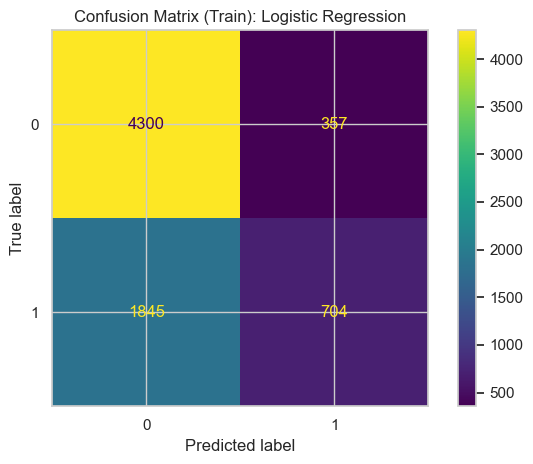

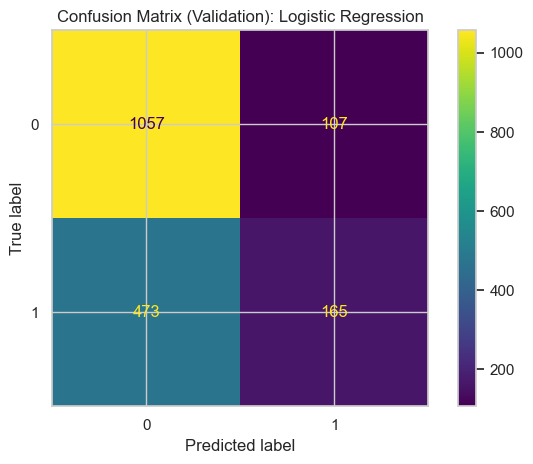

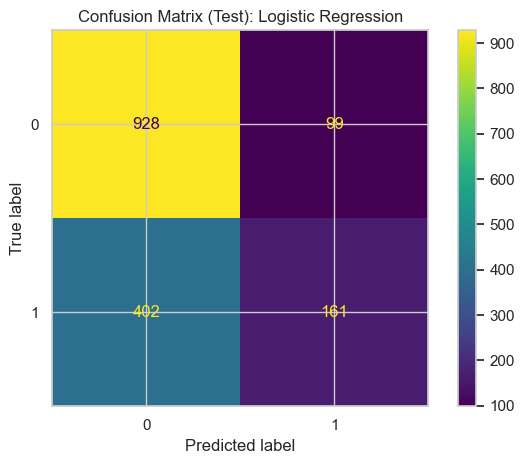

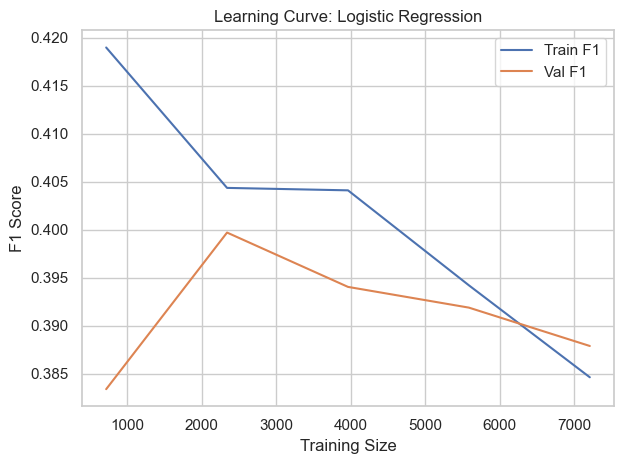

Training: Random Forest


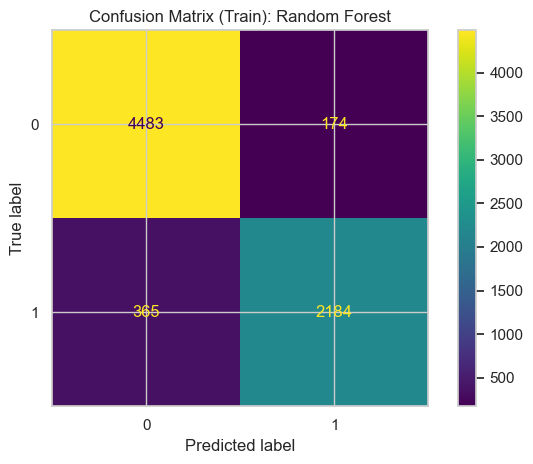

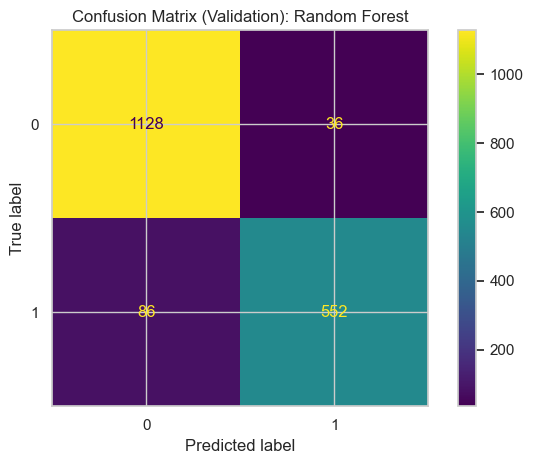

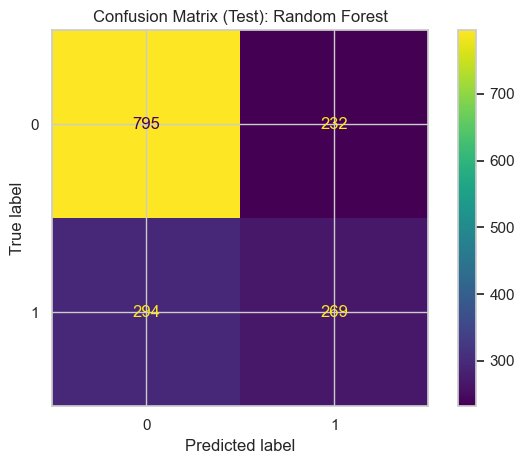

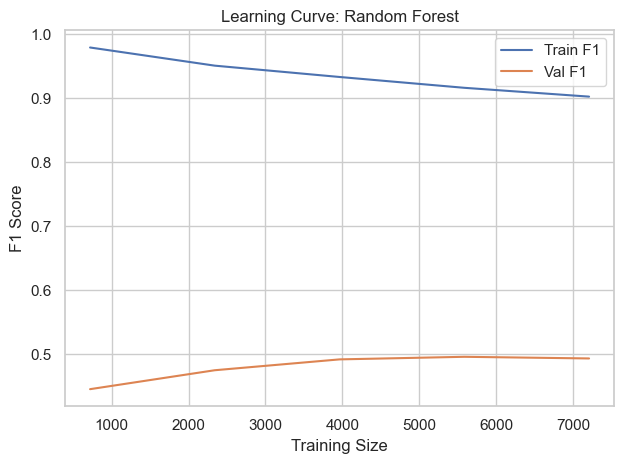

Training: XGBoost


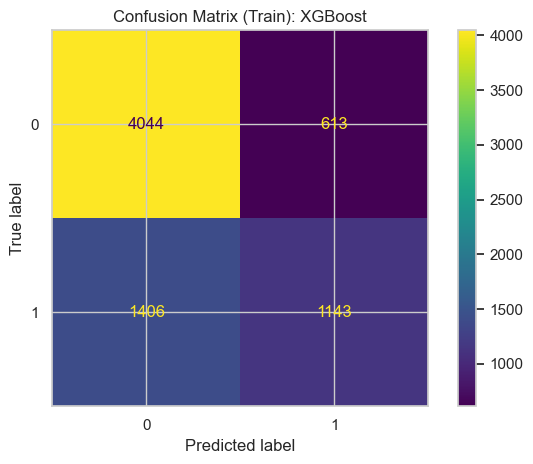

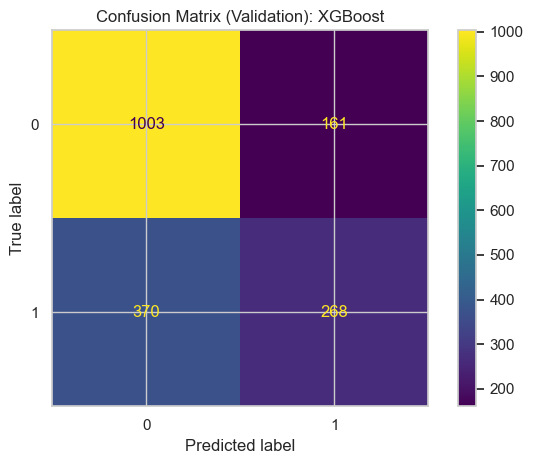

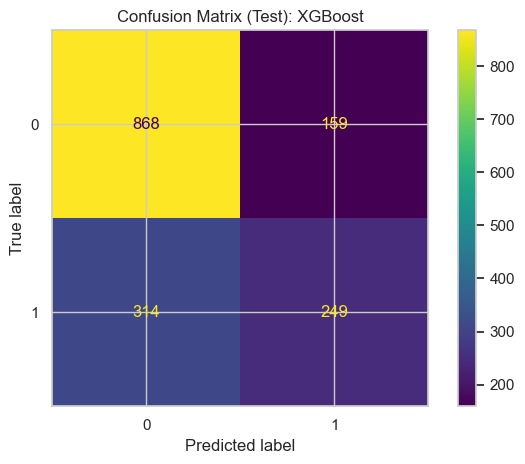

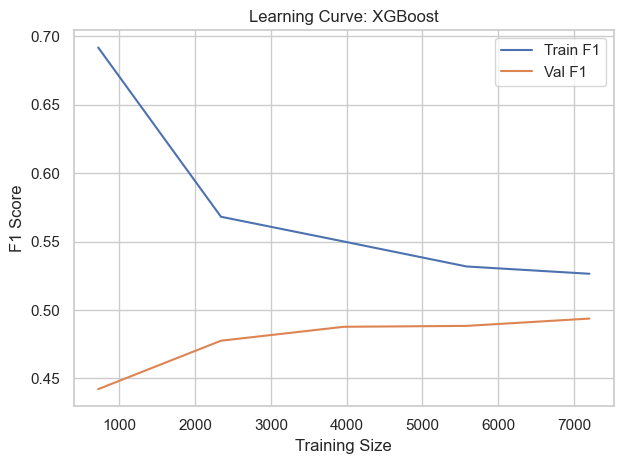

,Set,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Train,Logistic Regression,0.694,0.664,0.276,0.390,0.711
1,Validation,Logistic Regression,0.678,0.607,0.259,0.363,0.703
2,Test,Logistic Regression,0.685,0.619,0.286,0.391,0.704
3,Train,Random Forest,0.925,0.926,0.857,0.890,0.978
4,Validation,Random Forest,0.932,0.939,0.865,0.900,0.980
5,Test,Random Forest,0.669,0.537,0.478,0.506,0.680
6,Train,XGBoost,0.720,0.651,0.448,0.531,0.750
7,Validation,XGBoost,0.705,0.625,0.420,0.502,0.742
8,Test,XGBoost,0.703,0.610,0.442,0.513,0.724


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV, learning_curve, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)
import joblib
import os

# === Load Data ===
df = pd.read_csv("../data/cox_violent_parsed_filt_dedup_featureselected_cleaned_encoded.csv")
X = df.drop("is_recid", axis=1)
y = df["is_recid"]

# === Split ===
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, stratify=y_trainval, random_state=42)

# === Setup ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
os.makedirs("../reports", exist_ok=True)
os.makedirs("../models", exist_ok=True)

# === Top Models ===
top_models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "Random Forest": Pipeline([
        ("clf", RandomForestClassifier(random_state=42))
    ]),
    "XGBoost": Pipeline([
        ("clf", XGBClassifier(eval_metric='logloss', random_state=42))
    ])
}

param_grids = {
    "Logistic Regression": {"clf__C": [0.01, 0.1, 1, 10]},
    "Random Forest": {"clf__n_estimators": [100], "clf__max_depth": [None, 10]},
    "XGBoost": {"clf__n_estimators": [50, 100], "clf__max_depth": [3, 5]}
}

# === Evaluate ===
metrics = []
for name, pipe in top_models.items():
    print(f"Training: {name}")
    grid = GridSearchCV(pipe, param_grids[name], scoring="f1", cv=cv, n_jobs=-1)
    grid.fit(X_trainval, y_trainval)
    best_model = grid.best_estimator_

    joblib.dump(best_model, f"../models/{name.lower().replace(' ', '_')}_semi_tuned.pkl")

    for split_name, X_split, y_split in [("Train", X_train, y_train), ("Validation", X_val, y_val), ("Test", X_test, y_test)]:
        y_pred = best_model.predict(X_split)
        y_proba = best_model.predict_proba(X_split)[:, 1]
        acc = accuracy_score(y_split, y_pred)
        prec = precision_score(y_split, y_pred)
        rec = recall_score(y_split, y_pred)
        f1 = f1_score(y_split, y_pred)
        auc = roc_auc_score(y_split, y_proba)

        metrics.append({
            "Set": split_name, "Model": name, "Accuracy": round(acc, 3), "Precision": round(prec, 3),
            "Recall": round(rec, 3), "F1 Score": round(f1, 3), "AUC": round(auc, 3)
        })

        # Save Confusion Matrix and Report
        cm = confusion_matrix(y_split, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.title(f"Confusion Matrix ({split_name}): {name}")
        plt.tight_layout()
        plt.savefig(f"../reports/confmatrix_{split_name.lower()}_{name.lower().replace(' ', '_')}.png")
        plt.show()

        with open(f"../reports/classification_report_{split_name.lower()}_{name.lower().replace(' ', '_')}.txt", "w") as f:
            f.write(classification_report(y_split, y_pred))

    # === Learning Curve ===
    train_sizes, train_scores, val_scores = learning_curve(
        best_model, X_trainval, y_trainval, cv=cv, scoring="f1",
        train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
    )
    plt.figure()
    plt.plot(train_sizes, train_scores.mean(axis=1), label="Train F1")
    plt.plot(train_sizes, val_scores.mean(axis=1), label="Val F1")
    plt.xlabel("Training Size")
    plt.ylabel("F1 Score")
    plt.title(f"Learning Curve: {name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"../reports/learning_curve_{name.lower().replace(' ', '_')}.png")
    plt.show()

# === Final Export ===
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv("../reports/semi_tuned_model_metrics_summary.csv", index=False)
metrics_df


**For completeness only: Evaluate completely untuned base of Random Forest, XGBoost and baseline model Logistic Regression regarding metrics and learning curves. 

Evaluating baseline for: Random Forest


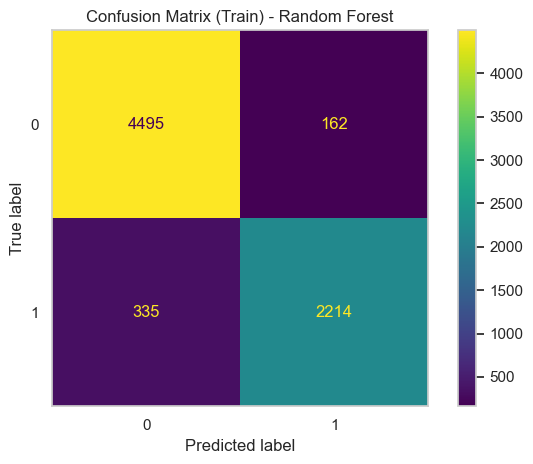

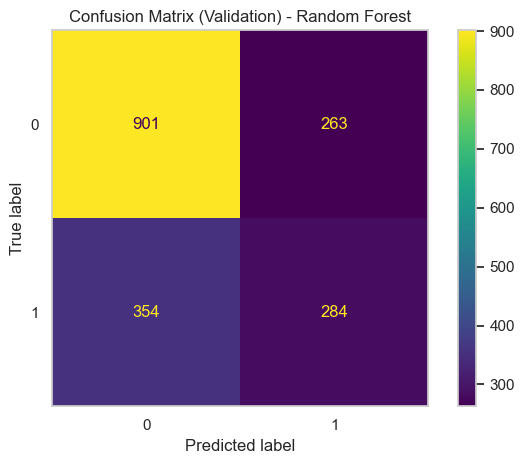

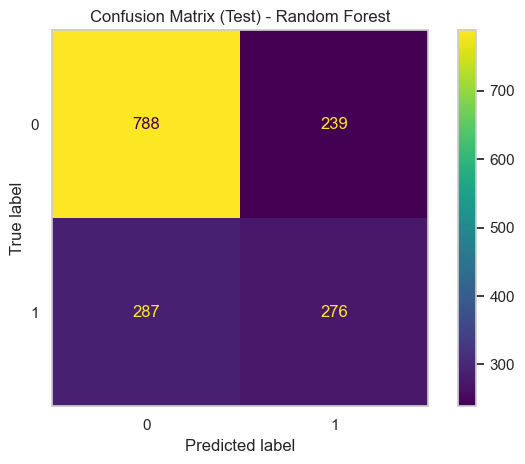

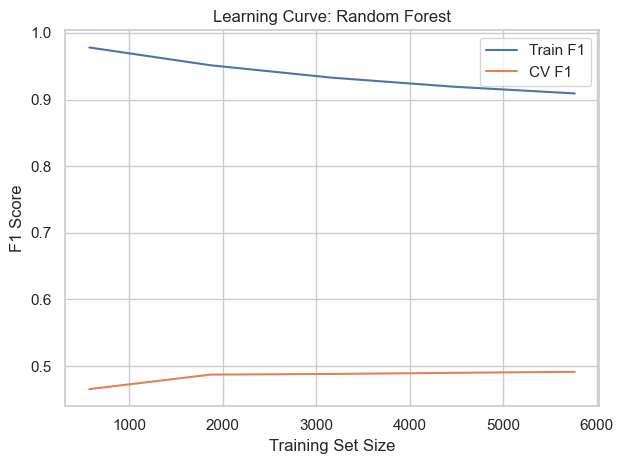

Evaluating baseline for: XGBoost


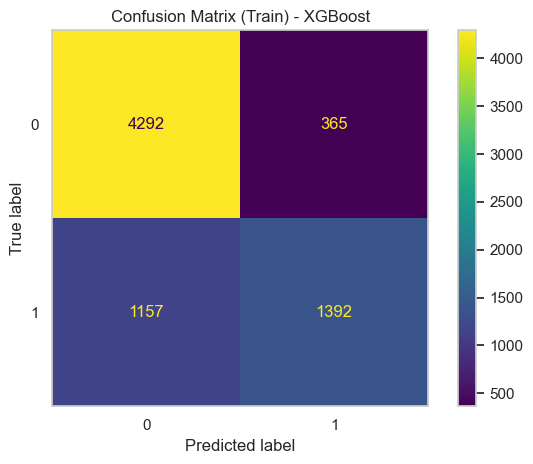

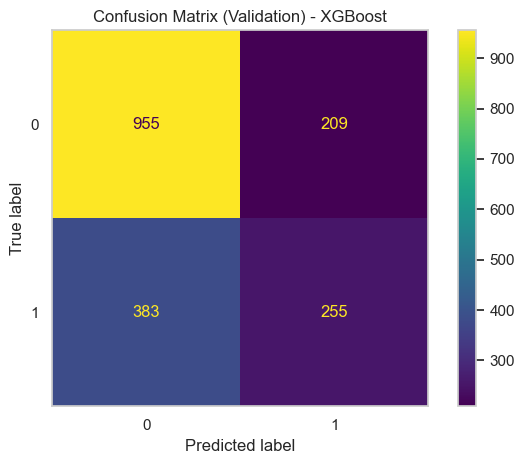

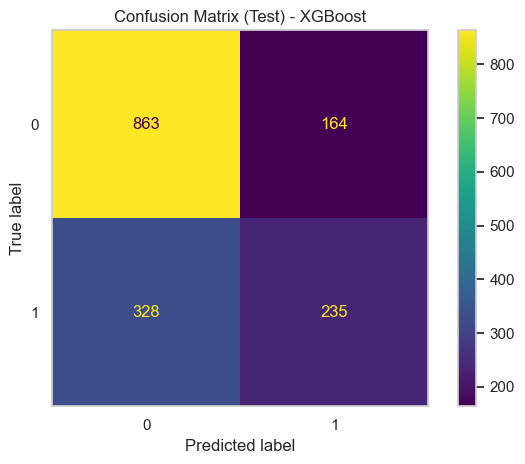

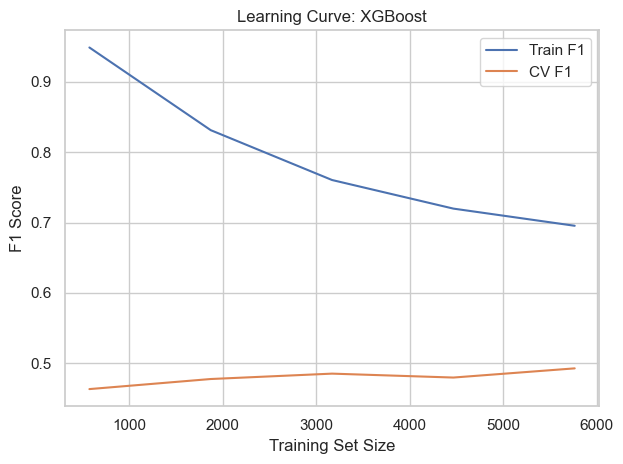

Evaluating baseline for: Logistic Regression


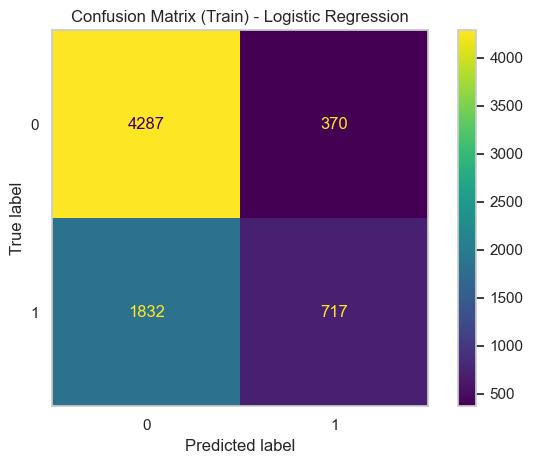

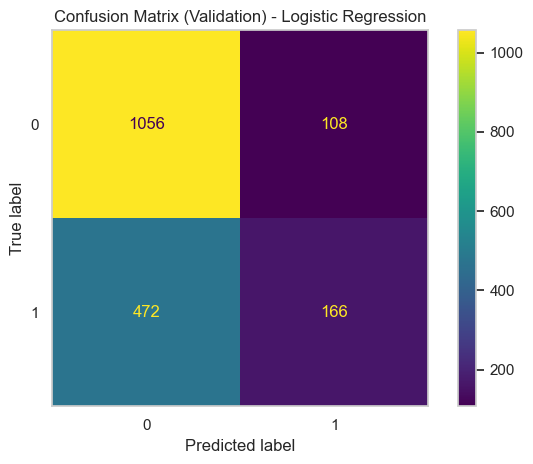

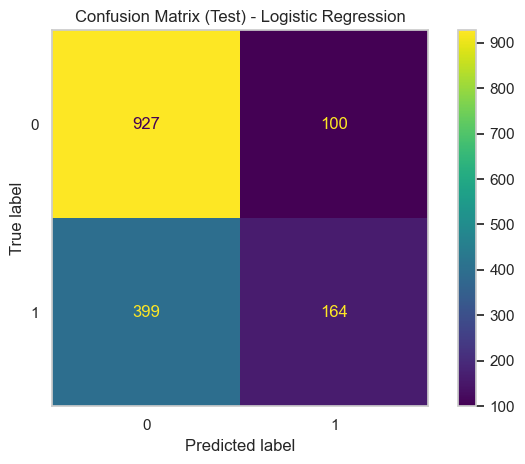

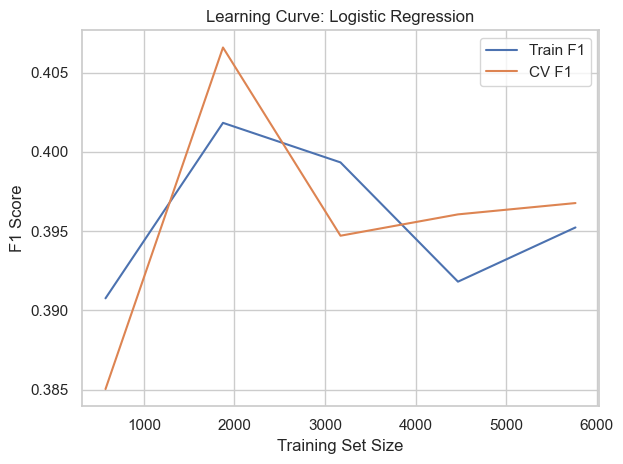

,Set,Model,Threshold,Accuracy,Precision,Recall,F1 Score,AUC
0,Train,Random Forest,0.5,0.931,0.932,0.869,0.899,0.981
1,Validation,Random Forest,0.5,0.658,0.519,0.445,0.479,0.658
2,Test,Random Forest,0.5,0.669,0.536,0.490,0.512,0.677
3,Train,XGBoost,0.5,0.789,0.792,0.546,0.647,0.853
4,Validation,XGBoost,0.5,0.671,0.550,0.400,0.463,0.681
5,Test,XGBoost,0.5,0.691,0.589,0.417,0.489,0.702
6,Train,Logistic Regression,0.5,0.694,0.660,0.281,0.394,0.711
7,Validation,Logistic Regression,0.5,0.678,0.606,0.260,0.364,0.703
8,Test,Logistic Regression,0.5,0.686,0.621,0.291,0.397,0.705


In [ ]:
# **For completeness only: Evaluate completely untuned base of Random Forest, XGBoost and baseline model Logistic Regression regarding metrics and learning curves. 

import os
import json
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# === Load Data ===
df = pd.read_csv("../data/cox_violent_parsed_filt_dedup_featureselected_cleaned_encoded.csv")
X = df.drop("is_recid", axis=1)
y = df["is_recid"]

# === Create Output Folders ===
os.makedirs("../reports/baseline", exist_ok=True)
os.makedirs("../models/baseline", exist_ok=True)

# === Split Data ===
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, stratify=y_trainval, random_state=42
)

# === Models Dictionary ===
models = {
    "Random Forest": Pipeline([
        ("clf", RandomForestClassifier(random_state=42))
    ]),
    "XGBoost": Pipeline([
        ("clf", XGBClassifier(eval_metric="logloss", random_state=42))
    ]),
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, random_state=42))
    ])
}

# === Cross-validation Setup ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# === Evaluation Helper ===
def evaluate_model(name, model, X_train, y_train, X_val, y_val, X_test, y_test):
    evaluation_results = []

    model.fit(X_train, y_train)
    joblib.dump(model, f"../models/baseline/{name.lower().replace(' ', '_')}_baseline.pkl")

    for set_name, X_data, y_data in [("Train", X_train, y_train), ("Validation", X_val, y_val), ("Test", X_test, y_test)]:
        y_pred = model.predict(X_data)
        y_proba = model.predict_proba(X_data)[:, 1]

        acc = accuracy_score(y_data, y_pred)
        prec = precision_score(y_data, y_pred)
        rec = recall_score(y_data, y_pred)
        f1 = f1_score(y_data, y_pred)
        auc = roc_auc_score(y_data, y_proba)
        cm = confusion_matrix(y_data, y_pred)

        # Save confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.named_steps["clf"].classes_)
        disp.plot()
        plt.title(f"Confusion Matrix ({set_name}) - {name}")
        plt.grid(False)
        plt.tight_layout()
        plt.savefig(f"../reports/baseline/confusion_matrix_{set_name.lower()}_{name.lower().replace(' ', '_')}.png")
        plt.show()

        # Save classification report
        report = classification_report(y_data, y_pred, target_names=["No Recidivism", "Recidivism"])
        with open(f"../reports/baseline/classification_report_{set_name.lower()}_{name.lower().replace(' ', '_')}.txt", "w") as f:
            f.write(report)

        evaluation_results.append({
            "Set": set_name,
            "Model": name,
            "Threshold": 0.5,
            "Accuracy": round(acc, 3),
            "Precision": round(prec, 3),
            "Recall": round(rec, 3),
            "F1 Score": round(f1, 3),
            "AUC": round(auc, 3)
        })

    # Learning Curve
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train, y_train, cv=cv, scoring="f1",
        train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1, shuffle=True, random_state=42
    )
    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)

    plt.figure()
    plt.plot(train_sizes, train_mean, label="Train F1")
    plt.plot(train_sizes, val_mean, label="CV F1")
    plt.title(f"Learning Curve: {name}")
    plt.xlabel("Training Set Size")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"../reports/baseline/learning_curve_{name.lower().replace(' ', '_')}.png")
    plt.show()

    return evaluation_results

# === Run for All Models ===
results = []
for name, model in models.items():
    print(f"Evaluating baseline for: {name}")
    res = evaluate_model(name, model, X_train, y_train, X_val, y_val, X_test, y_test)
    results.extend(res)

# === Save All Results ===
baseline_df = pd.DataFrame(results)
baseline_df.to_csv("../reports/baseline/untuned_model_metrics_summary.csv", index=False)

baseline_df

Compare models, semi-tuned with cv-GridSearch for model selection, which one performs best? 

In [ ]:
import pandas as pd

# === Load baseline results
metrics_df = pd.read_csv("../reports/semi_tuned_model_metrics_summary.csv")

# === Sort priority: Test > Validation > Train, then by metrics
set_order = {"Test": 0, "Validation": 1, "Train": 2}
metrics_df["SetOrder"] = metrics_df["Set"].map(set_order)

sorted_metrics_df = metrics_df.sort_values(
    by=["SetOrder", "Precision", "F1 Score", "Recall", "AUC", "Accuracy"],
    ascending=[True, False, False, False, False, False]
).reset_index(drop=True)

# === Identify best model on the TEST set
best_test_model = sorted_metrics_df[sorted_metrics_df["Set"] == "Test"].iloc[0]
print("\nBest semi-tuned model based on TEST Set by priority-ranked metrics:")
print(best_test_model[["Set", "Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC"]])

# === Optional: Save comparison
sorted_metrics_df.to_csv("../reports/semi_tuned_model_comparison_sorted.csv", index=False)
sorted_metrics_df



Best semi-tuned model based on TEST Set by priority-ranked metrics:
Set                         Test
Model        Logistic Regression
Accuracy                   0.685
Precision                  0.619
Recall                     0.286
F1 Score                   0.391
AUC                        0.704
Name: 0, dtype: object


,Set,Model,Accuracy,Precision,Recall,F1 Score,AUC,SetOrder
0,Test,Logistic Regression,0.685,0.619,0.286,0.391,0.704,0
1,Test,XGBoost,0.703,0.610,0.442,0.513,0.724,0
2,Test,Random Forest,0.669,0.537,0.478,0.506,0.680,0
3,Validation,Random Forest,0.932,0.939,0.865,0.900,0.980,1
4,Validation,XGBoost,0.705,0.625,0.420,0.502,0.742,1
5,Validation,Logistic Regression,0.678,0.607,0.259,0.363,0.703,1
6,Train,Random Forest,0.925,0.926,0.857,0.890,0.978,2
7,Train,Logistic Regression,0.694,0.664,0.276,0.390,0.711,2
8,Train,XGBoost,0.720,0.651,0.448,0.531,0.750,2
